# Author Information

**Author:** CHUA JINGXUAN

**Taylor's Student ID:** 0365376

**Email:** 0365376@sd.taylors.edu.my

**Note:** This Jupyter Notebook was written by CHUA JINGXUAN. If you find any issues, have questions, or want to provide feedback, please don't hesitate to reach out. Thank you for exploring this notebook!

**Date Written**: 28/07/2024 (SUN)

**Last Updated**: 30/07/2024 (TUE)

---
# ITS70804 Text and Image Processing: ASSIGNMENT 3
---

# Trial 01: ResNet50 (Teacher) + DeiT-Tiny (Student)

# Importing Essential Libraries

In [ ]:
!pip install timm

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
import torchvision.models as models
import timm
import time
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, accuracy_score

# 1.0 Data Loading and Apply Augmentation

In [ ]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize((224, 224)),  # Resize 224 x 224
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]),  # Normalization for CIFAR-10
    ])

# Loading CIFAR-10 dataset
train_dataset = CIFAR10(root='./data', train=True, download=True, transform=get_transforms())
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_dataset = CIFAR10(root='./data', train=False, download=True, transform=get_transforms())
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


# 2.0 Instantiate Teacher and Student Model

In [ ]:
# Initialize the teacher model (ResNet50)
teacher_model = models.resnet50(pretrained=True)
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 10)  # Adjust for CIFAR-10
teacher_model = teacher_model.eval()  # Set to evaluation mode

# Initialize the student model (DeiT Tiny)
student_model = timm.create_model('deit_tiny_patch16_224', pretrained=False, num_classes=10)
student_model.train()

# Move models to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teacher_model = teacher_model.to(device)
student_model = student_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Function to count the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters
teacher_params = count_parameters(teacher_model)
student_params = count_parameters(student_model)
print(f"Number of parameters in teacher model (ResNet50): {teacher_params}")
print(f"Number of parameters in student model (DeiT Tiny): {student_params}")

Number of parameters in teacher model (ResNet50): 23528522
Number of parameters in student model (DeiT Tiny): 5526346


# 3.0 Define Loss Function and Optimizer

In [ ]:
optimizer = torch.optim.Adam(student_model.parameters(), lr=0.0005)  # Smaller learning rate for fine-tuning

def distillation_loss(student_output, teacher_output, labels, T=3.0):
    soft_loss = F.kl_div(F.log_softmax(student_output/T, dim=1), F.softmax(teacher_output/T, dim=1), reduction='batchmean')
    hard_loss = F.cross_entropy(student_output, labels)
    return soft_loss + hard_loss

temperature = 3.0  # Temperature for softening probabilities

# 4.0 Model Training Loop and Timing

In [ ]:
num_epochs = 50
train_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    student_model.train()
    total_loss = 0
    start_time = time.time() # Start timing
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        with torch.no_grad():
            teacher_outputs = teacher_model(images)
        student_outputs = student_model(images)

        loss = distillation_loss(student_outputs, teacher_outputs, labels, temperature)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_duration = time.time() - start_time # Calculate duration of epoch
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Evaluate the model on the test set
    student_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = student_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total * 100
    test_accuracies.append(accuracy)

    # Print training status
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Duration: {epoch_duration:.2f} seconds')

Epoch 1/50, Loss: 1.8670, Accuracy: 41.23%, Duration: 198.56 seconds
Epoch 2/50, Loss: 1.6007, Accuracy: 48.10%, Duration: 198.80 seconds
Epoch 3/50, Loss: 1.4999, Accuracy: 50.21%, Duration: 198.62 seconds
Epoch 4/50, Loss: 1.4342, Accuracy: 52.75%, Duration: 199.51 seconds
Epoch 5/50, Loss: 1.3846, Accuracy: 55.49%, Duration: 198.81 seconds
Epoch 6/50, Loss: 1.3306, Accuracy: 57.52%, Duration: 199.13 seconds
Epoch 7/50, Loss: 1.2827, Accuracy: 58.69%, Duration: 200.52 seconds
Epoch 8/50, Loss: 1.2350, Accuracy: 59.82%, Duration: 200.33 seconds
Epoch 9/50, Loss: 1.1956, Accuracy: 61.79%, Duration: 200.24 seconds
Epoch 10/50, Loss: 1.1574, Accuracy: 61.91%, Duration: 199.91 seconds
Epoch 11/50, Loss: 1.1196, Accuracy: 64.21%, Duration: 200.73 seconds
Epoch 12/50, Loss: 1.0872, Accuracy: 64.44%, Duration: 200.40 seconds
Epoch 13/50, Loss: 1.0535, Accuracy: 65.63%, Duration: 200.67 seconds
Epoch 14/50, Loss: 1.0199, Accuracy: 65.95%, Duration: 200.47 seconds
Epoch 15/50, Loss: 0.9859, Ac

In [ ]:
torch.save(student_model.state_dict(), './resnet50_deit_student.pth')

# 5.0 Evaluate the Model

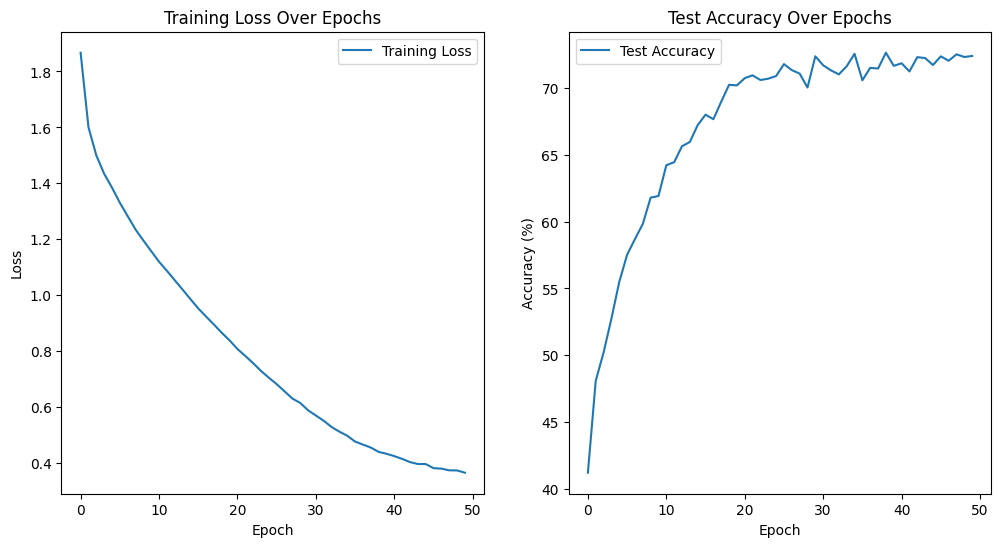

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

In [ ]:
# Calculate and display classification report
all_preds = []
all_targets = []
student_model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = student_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_targets.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_targets, all_preds)
print(f'Accuracy: {accuracy * 100:.2f}%')
print('Classification Report:\n', classification_report(all_targets, all_preds))

Accuracy: 72.04%
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75      1000
           1       0.83      0.80      0.82      1000
           2       0.64      0.64      0.64      1000
           3       0.54      0.58      0.56      1000
           4       0.75      0.61      0.67      1000
           5       0.63      0.65      0.64      1000
           6       0.78      0.76      0.77      1000
           7       0.74      0.76      0.75      1000
           8       0.80      0.83      0.82      1000
           9       0.76      0.83      0.79      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000

